In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio 
from collections import defaultdict

from sklearn.preprocessing import MinMaxScaler

from tslearn.piecewise import PiecewiseAggregateApproximation

from matrixprofile import *

import stumpy
from tqdm.notebook import tqdm
import gc
from matplotlib.patches import Rectangle


import warnings
warnings.filterwarnings('ignore')

In [3]:
X_train = np.load("DATASETS/TimeSeriesTrimmedDS//X_train15.npy")
y_train = pd.read_csv('DATASETS/TimeSeriesTrimmedDS/y_train.csv')

# Matrix Profile

In [60]:
w=1000
matrix_profile = list()
matrix_profile_index = list()
for ts in tqdm(X_train):
    mp = stumpy.stump(ts, m=w)
    matrix_profile.append(mp[:,0])
    matrix_profile_index.append(mp[:,1])

  0%|          | 0/1828 [00:00<?, ?it/s]

# Motif Discovery

modality                                 audio-only
vocal_channel                                  song
emotion                                     fearful
emotional_intensity                          normal
statement              Dogs are sitting by the door
repetition                                      1st
actor                                             1
sex                                               M
filename                   03-02-06-01-02-01-01.wav
Name: 98, dtype: object


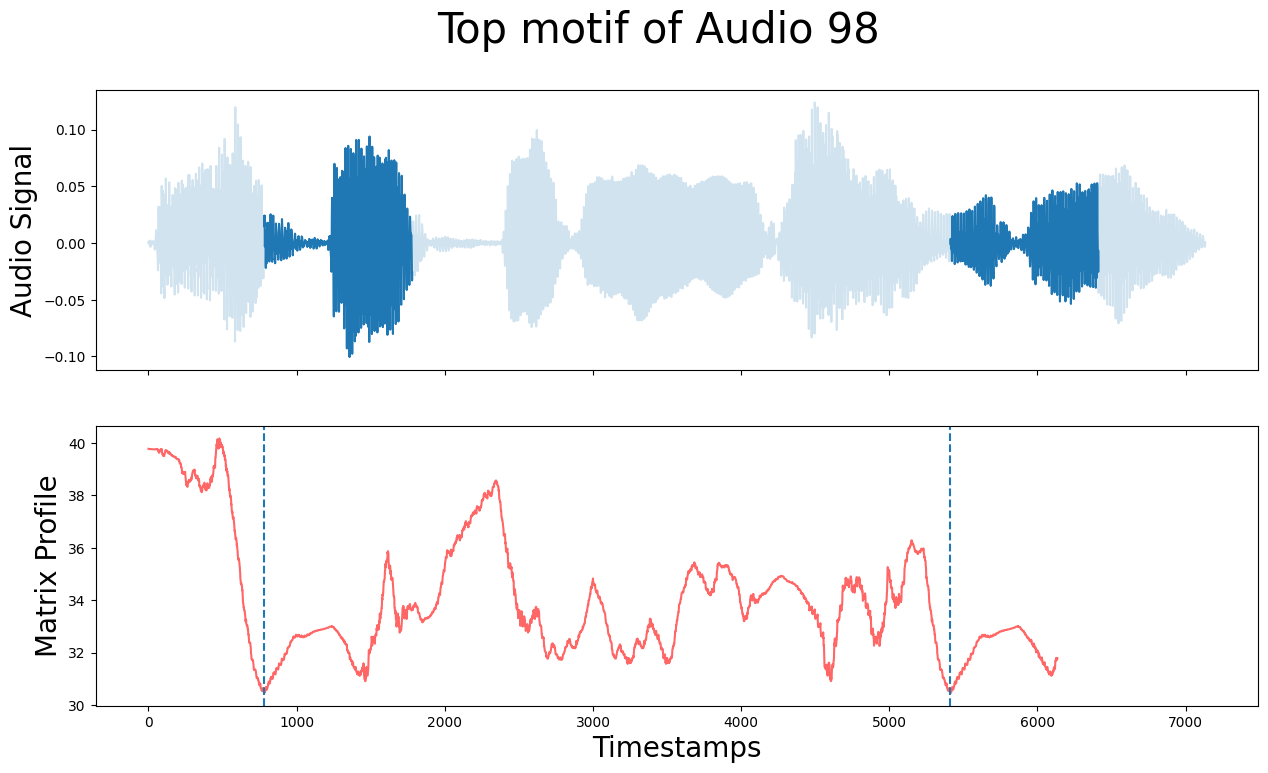

In [66]:
index_ts=98
ts=X_train[index_ts]
mp=matrix_profile[index_ts]
mpi=matrix_profile_index[index_ts]

mo,mod= motifs.motifs(ts, (mp, mpi), max_motifs=1,n_neighbors=3)


fig, axs = plt.subplots(2, sharex=True,figsize=(15,8))
plt.suptitle('Top motif of Audio %i'%index_ts, fontsize='30')
axs[0].plot(ts,alpha=0.2)
axs[0].set_ylabel('Audio Signal', fontsize='20')

axs[1].plot(mp,alpha=0.6,color="red")  
axs[1].set_xlabel('Timestamps', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')

for i in range(len(mo)):
    for n in range(len(mo[i])):
        m_shape = ts[mo[i][n]:mo[i][n]+w]
        axs[0].plot(range(mo[i][n],mo[i][n]+w), m_shape, color='C{}'.format(i), lw=1.5)
        #rect = Rectangle((mo[i][n], np.min(ts)), w, np.max(ts)-np.min(ts), facecolor=colors[i],alpha=0.2)
        #axs[0].add_patch(rect)#plot the grey rectangle
        axs[1].axvline(x=mo[i][n], linestyle="dashed",color='C{}'.format(i))#plot the dashed line
print(y_train.iloc[index_ts])
Audio(ts[~np.isnan(ts)],rate=48000/15)

In [67]:
Audio(X_train[index_ts][mo[0][1]:mo[0][1]+w],rate=48000/15)

In [68]:
Audio(X_train[index_ts][mo[0][0]:mo[0][0]+w],rate=48000/15)

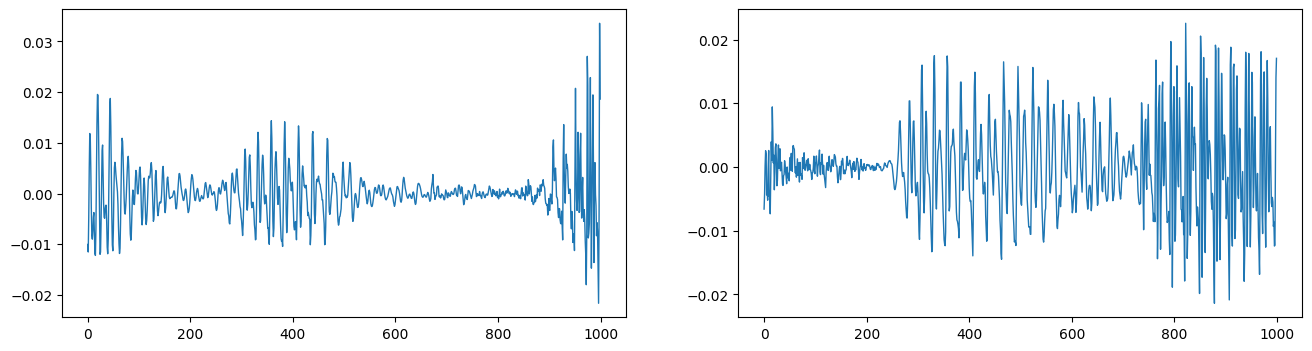

In [7]:
for color,m in enumerate(mo):
    fig, axs = plt.subplots(nrows=1,ncols=2, sharex=True,figsize=(16,4))
    for idx,i in enumerate(m):
        m_shape = ts[i:i+w]
        axs[idx].plot( m_shape, color='C{}'.format(color), lw=1)

# Top motif of all timeseries
first we calculate for all the time series all the top motif, afther that we compare each pair of motif found and keep the most similar. in the end we are gonna get the motif that are the most similar across all the dataset

In [69]:
from scipy.spatial.distance import euclidean

In [70]:
motif_shapes=[]
for i in range(X_train.shape[0]):
    mo,_= motifs.motifs(X_train[i], (matrix_profile[i], matrix_profile_index[i]), max_motifs=1,n_neighbors=1,ex_zone=800)
    m_shape = X_train[i][mo[0][0]:mo[0][0]+w]
    motif_shapes.append(m_shape)

In [182]:
top_shapes=[]

for i in tqdm(range(len(motif_shapes))):
    similar_shape=[]
    indexes=[]
    for j in range(i+1,len(motif_shapes)):
        dist=euclidean(motif_shapes[i], motif_shapes[j])
        if((dist<0.015)&(dist!=0)):
            if(len(similar_shape)==0):
                shape_i=motif_shapes[i]
                shape_j=motif_shapes[j]
                similar_shape.append(shape_i)
                similar_shape.append(shape_j)
                indexes.append(i)
                indexes.append(j)
            else:
                shape_j=motif_shapes[j]
                similar_shape.append(shape_j)
                indexes.append(j)
    if((len(similar_shape)!=0)&(len(similar_shape)>2)):
        print(len(indexes))
        top_shapes.append([similar_shape,indexes])
print(len(top_shapes))

  0%|          | 0/1828 [00:00<?, ?it/s]

11
7
5
6
4
3
6


## Most similar motif

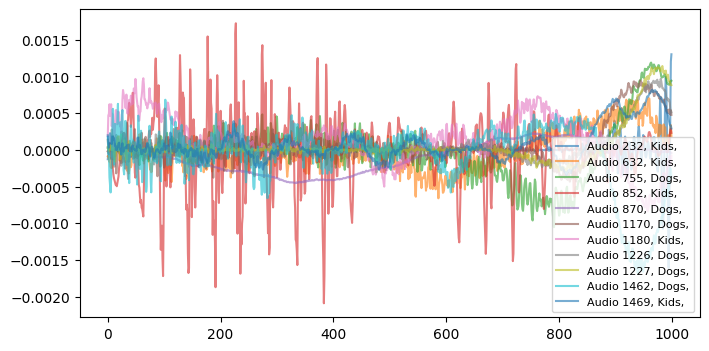

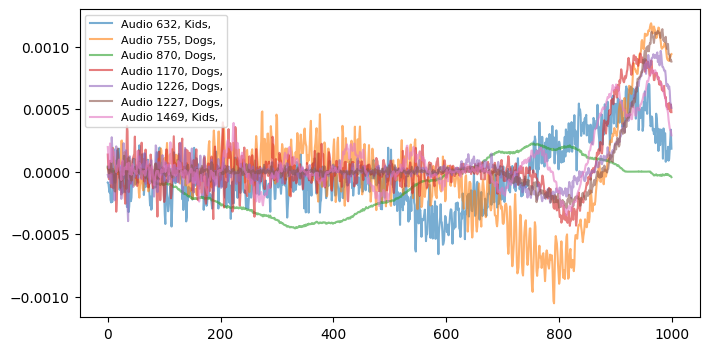

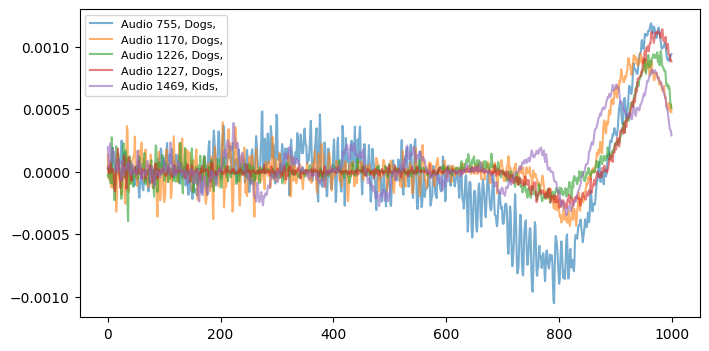

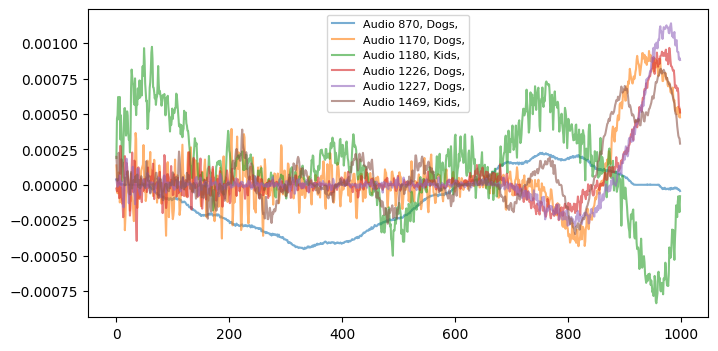

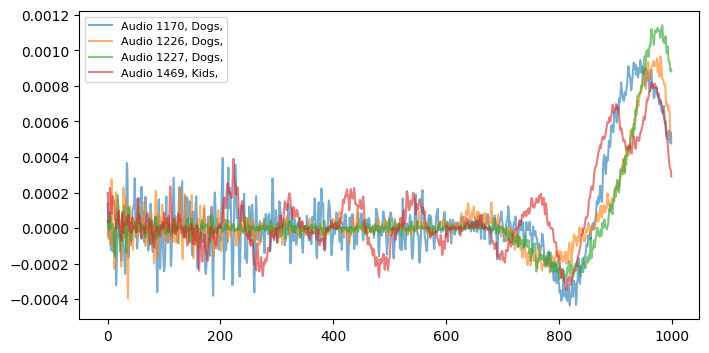

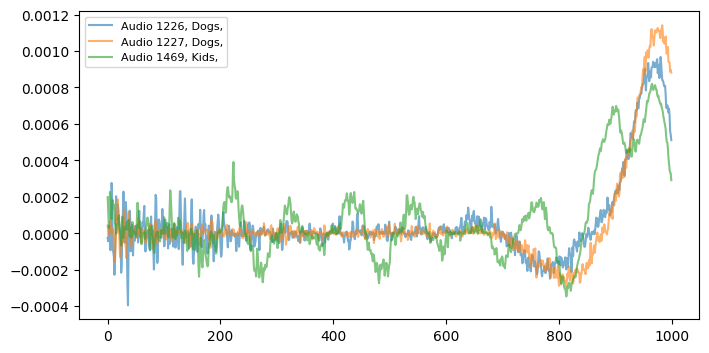

In [183]:
for m in top_shapes:
    plt.figure(figsize=(8, 4))
    motifs=m[0]
    indexes=m[1]
    for i,shape in enumerate(motifs):
        plt.plot(shape,color='C{}'.format(i),alpha=0.6,label='Audio {idx}, {statement},'.format(idx=indexes[i],statement=y_train.iloc[indexes[i]].statement.split()[0]))
    plt.legend(loc='best', fontsize=8)
    plt.show()

# Top Discords of all timeseriesTop motif of all timeseries

In [12]:
from matrixprofile.discords import discords

In [13]:
anomalies_shapes=[]
for i in range(X_train.shape[0]):
    a= discords(matrix_profile[i], ex_zone=800, k=1)[0]
    a_shape = X_train[i][a:a+w]
    anomalies_shapes.append(a_shape)

In [170]:
common_anoms=[]
for i in tqdm(range(len(anomalies_shapes))):
    similar_shape=[]
    indexes=[]
    for j in range(i+1,len(anomalies_shapes)):
        dist=euclidean(anomalies_shapes[i], anomalies_shapes[j])
        if((dist<0.009)):
            if(len(similar_shape)==0):
                shape_i=motif_shapes[i]
                shape_j=motif_shapes[j]
                similar_shape.append(shape_i)
                similar_shape.append(shape_j)
                indexes.append(i)
                indexes.append(j)
            else:
                shape_j=motif_shapes[j]
                similar_shape.append(shape_j)
                indexes.append(j)
    if(len(similar_shape)!=0):
        common_anoms.append([similar_shape,indexes])
print(len(top_shapes))

  0%|          | 0/1828 [00:00<?, ?it/s]

8


## Most similar discords

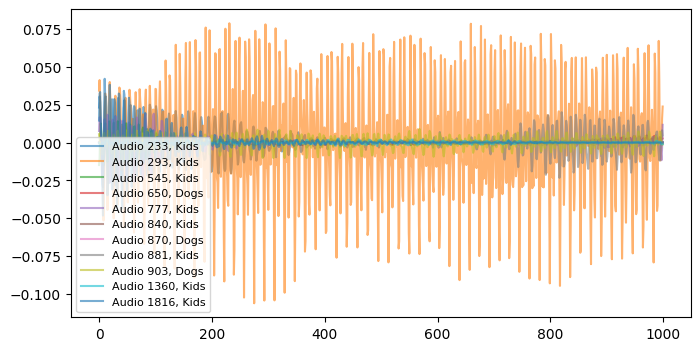

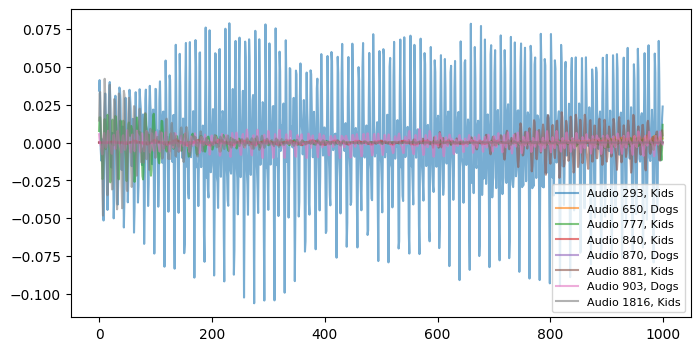

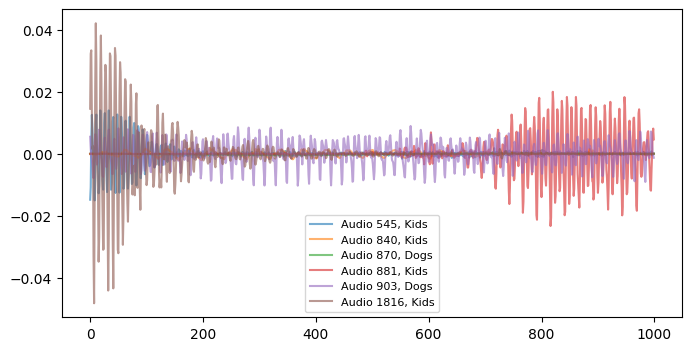

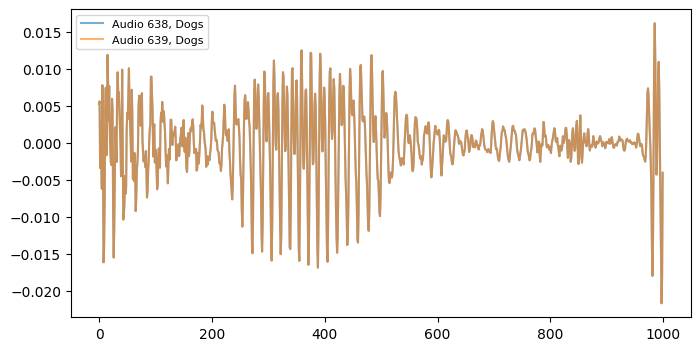

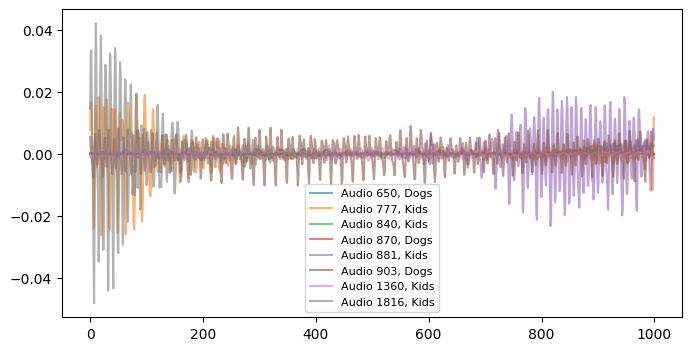

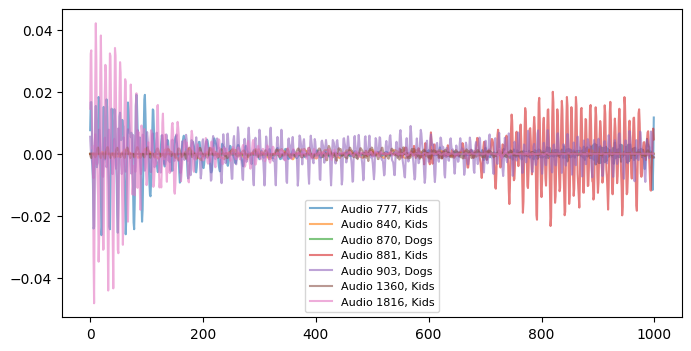

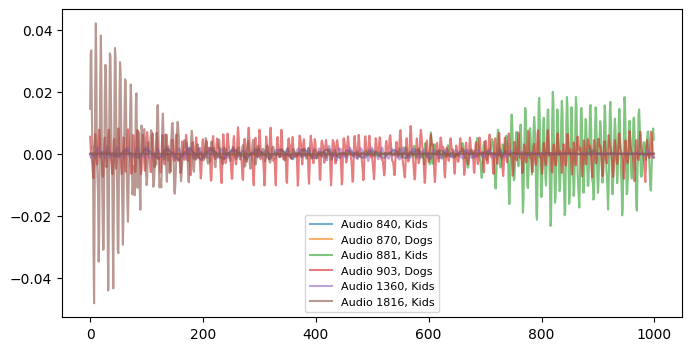

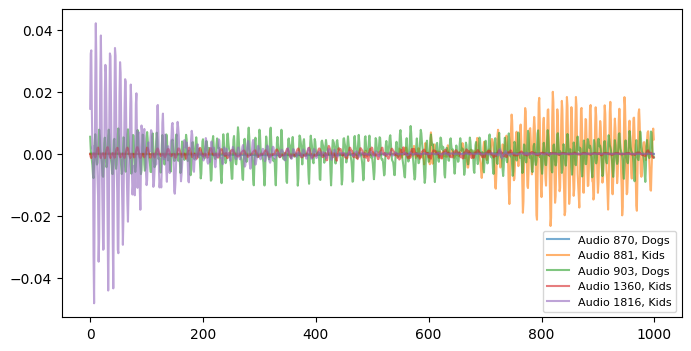

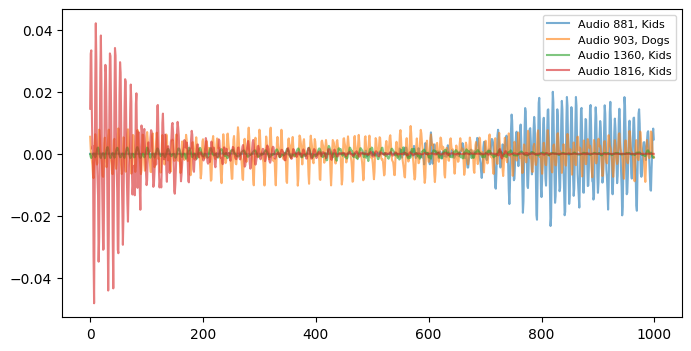

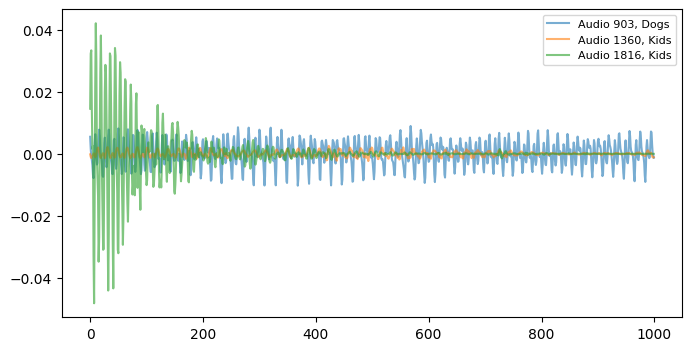

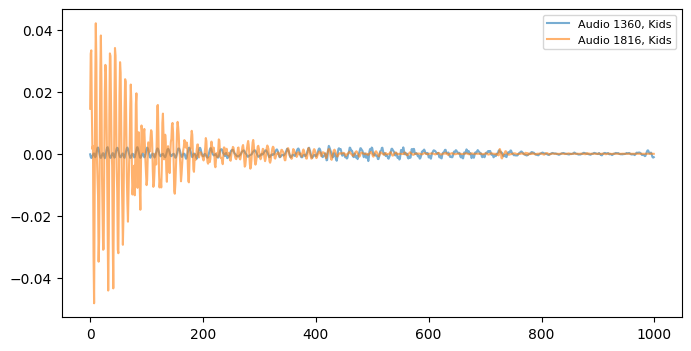

In [169]:
for a in common_anoms:
    plt.figure(figsize=(8, 4))
    motifs=a[0]
    indexes=a[1]
    for i,shape in enumerate(motifs):
        plt.plot(shape,color='C{}'.format(i),alpha=0.6,label='Audio {idx}, {statement}'.format(idx=indexes[i],statement=y_train.iloc[indexes[i]].statement.split()[0]))
    plt.legend(loc='best', fontsize=8)
    plt.show()